In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, Statevector, state_fidelity
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import Parameter # To enable parameterized circuits
from qiskit.circuit.library import SwapGate

import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from math import pi, sqrt
from matplotlib import pyplot as plt
import sys

# Define the number of qubits and classical bits for the superdense coding core
num_qubits_superdense = 2 # Alice's and Bob's qubits
num_cbits_superdense = 2 # For decoding the 2 classical bits

## Superdense Coding - Parameterized Circuit Approach

This section implements the superdense coding protocol using a single parameterized quantum circuit. Alice's encoding operations (Identity, Z, X, ZX) are implemented using `rz` and `rx` gates with `Parameter` objects, which are then assigned values (0 or pi) based on the 2-bit classical message.

In [30]:
# Define parameters for the angles of rotation for X and Z gates
xTheta = Parameter('xTheta')
yTheta = Parameter('yTheta')
zTheta = Parameter('zTheta')

def create_superdense_parameterized_circuit():
    # Initialize a quantum circuit with 2 qubits and 2 classical bits
    # Qubit 0 is Alice's, Qubit 1 is Bob's.
    # Classical bit 0 and 1 will store the decoded classical message.
    # The circuit will also include 3 additional qubits, which are used 
    # to facilitate the encoding and decoding process.
    qc = QuantumCircuit(num_qubits_superdense+3, num_cbits_superdense)

    # 1. Entanglement Creation (Initial shared Bell state)
    # Creates the |beta_00> state = (|00> + |11>)/sqrt(2)
    qc.h(0) # Apply Hadamard to Alice's qubit (qubit 0)
    qc.cx(0, 1) # Apply CNOT with Alice's qubit (0) as control and Bob's qubit (1) as target
    qc.swap(0, 4)
    qc.barrier() # Separator for visualization

    # 2. Alice's Encoding Operations (on her qubit, qubit 0)
    # These operations are parameterized by `angle_z` and `angle_x`.
    # If angle_z is pi, it acts as a Z gate; if 0, it's an Identity.
    # If angle_x is pi, it acts as an X gate; if 0, it's an Identity.
    # The order (RZ then RX) is chosen to align with ZX gate for '11' message.
    
    qc.rx(xTheta, 1) # Apply RX rotation based on angle_x parameter
    qc.ry(yTheta, 1) # Apply RY rotation based on angle_y parameter
    qc.rz(zTheta, 1) # Apply RZ rotation based on angle_z parameter
    qc.barrier()

    # 3. Bob's Decoding (Bell Measurement)
    # Bob receives Alice's qubit (qubit 0). He then performs operations with his qubit (qubit 1)
    # to decode the message. This involves a CNOT gate followed by a Hadamard gate.
    for i in range (1, num_qubits_superdense + 1):
        qc.swap(i, i+1)
    qc.barrier()

    # CNOT with Alice's qubit (0) as control and Bob's qubit (1) as target
    qc.cx(num_qubits_superdense+2, num_qubits_superdense + 1)
    qc.h(num_qubits_superdense+2) # Hadamard on Alice's qubit (qubit 0)
    qc.barrier()

    # 4. Measurement
    # Measure both qubits to obtain the classical bits representing the original message.
    qc.measure(num_qubits_superdense + 2, 0)
    qc.measure(num_qubits_superdense + 1, 1)

    return qc

# Create the parameterized superdense coding circuit template
qc = create_superdense_parameterized_circuit()

## Parameter Binding and Message Encoding

This section defines how classical 2-bit messages map to the parameters `xTheta` and `zTheta` for Alice's operations.

Based on your specification:
* **00**: Identity (no X or Z effect) -> `xTheta = 0`, `zTheta = 0`
* **01**: Z gate on Alice's qubit -> `xTheta = 0`, `zTheta = pi`
* **10**: X gate on Alice's qubit -> `xTheta = pi`, `zTheta = 0`
* **11**: ZX gate (Z then X) on Alice's qubit -> `xTheta = pi`, `zTheta = pi`

In [ ]:
def send(bits2):
    params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    if (bits2=='00'):
         params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    if (bits2=='10'):
        params = {zTheta: 0,     yTheta: 0,     xTheta: pi}
    if (bits2 == '01'):
        params = {zTheta: pi,     yTheta: 0, xTheta: 0}
    if (bits2=='11'):
        params = {zTheta: pi, yTheta: 0,     xTheta: pi}
    return params

def send_string(bits):
    param_sets = []
    if (len(bits)%2==1):
        bits=f"{bits}0"
    for i in range(0,len(bits),2):
        bits2 = bits[i:i+2]
        param_sets.append(send(bits2))
    return param_sets

def bits_to_bytes(bit_string):
    if len(bit_string) % 8 != 0:
        bit_string = bit_string.ljust((len(bit_string) + 7) // 8 * 8, '0')
    byte_list = [int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)]
    return bytes(byte_list)

def prepare_circuits_for_message_string(full_classical_message_string):
    """
    Prepares a list of bound circuits for a long classical message string.
    The string is broken into 2-bit blocks.
    """
    if len(full_classical_message_string) % 2 != 0:
        # Pad with a '0' if the message length is odd to ensure 2-bit blocks
        full_classical_message_string += '0'
        print(f"Warning: Message length was odd. Padded with '0' to: {full_classical_message_string}")

    circuits_to_run = []
    messages_sent_labels = [] # To keep track of original 2-bit message for result analysis

    for i in range(0, len(full_classical_message_string), 2):
        two_bit_block = full_classical_message_string[i:i+2]
        params = send_string(two_bit_block)
        
        # Assign parameters to the template to create a specific circuit for this block
        bound_circuit = qc.assign_parameters(params)
        
        # Optionally, give the circuit a name for easier identification in results
        bound_circuit.name = f"message_{two_bit_block}"
        
        circuits_to_run.append(bound_circuit)
        messages_sent_labels.append(two_bit_block)
        
    return circuits_to_run, messages_sent_labels

In [34]:
def recieve_string(job):
    message = ""
    for i in range(len(job.result())):
        result = job.result()[i].data.classical.get_counts()
        max=0
        mess_seg = ""
        for res in result:
            if (result[res]>max):
                mess_seg = res
                max = result[res]
        message = f"{message}{mess_seg}"
        #print(job2.result()[i].data.classical.get_counts())
    return message

def recieve_string_loaded_job(job):
    message = ""
    for i in range(len(job)):
        result = job[i].data.classical.get_counts()
        max=0
        mess_seg = ""
        for res in result:
            if (result[res]>max):
                mess_seg = res
                max = result[res]
        message = f"{message}{mess_seg}"
        #print(job2.result()[i].data.classical.get_counts())
    return message

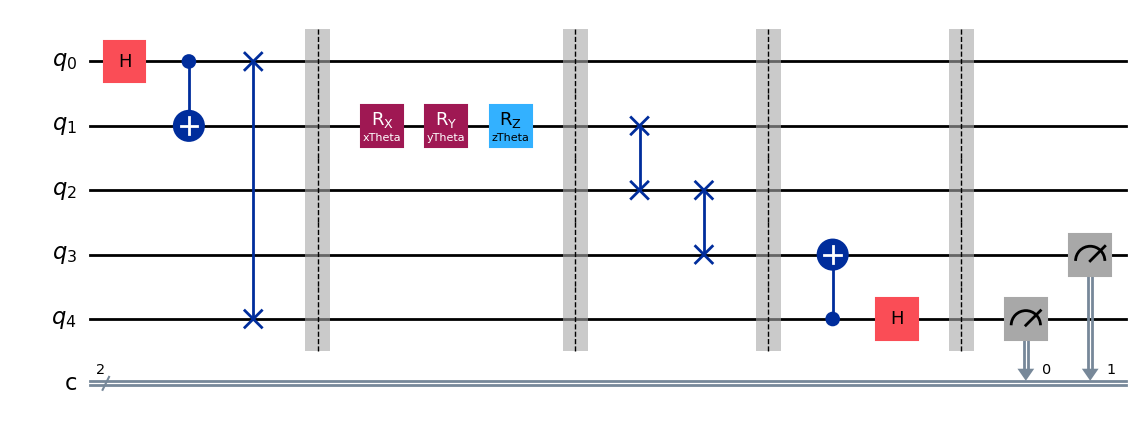

In [31]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer import AerSimulator
# backend = FakeSherbrooke()
backend = AerSimulator()
sampler = Sampler(backend)

# Create the "pass manager" that will perform the transpilation
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)

# Run the pass manager to generate the transpiled circuit
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw('mpl')

## Simulation and Decoding

This section sets up the simulator and runs a batch of circuits to demonstrate superdense coding for a long message.

In [37]:
# Example long classical message to send
param_sets = send_string("01101110010001010010")
# Prepare the list of circuits for batch execution
bound_circuits = [qc.assign_parameters(param) for param in param_sets]

# Run all bound circuits in a single job
job = sampler.run(bound_circuits, shots = 1)
result = job.result()
print(f"Job size: {str(sys.getsizeof(job))}")

Job size: 48


## Image Encoding/Decoding (Example - conceptual due to execution environment)

This section provides an example of how you might use superdense coding to transmit pixel data from an image. Note that reading local files (`Image.open`) and direct image reconstruction might not be fully supported in this execution environment.

In [ ]:
# Helper functions for raw image data processing
def read_raw_image_data_from_file(file_path):
    """
    Reads raw byte data from a binary image file.
    Expects a file where bytes directly represent pixel values.
    """
    try:
        with open(file_path, 'rb') as f: # 'rb' for read binary
            raw_bytes = f.read()
        return raw_bytes
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: Image file '{file_path}' not found. "
                                "Please ensure your raw binary image file is in the correct directory.")
    except Exception as e:
        raise IOError(f"Error reading raw image file '{file_path}': {e}")

def bytes_to_binary_string(raw_bytes_data):
    """
    Converts raw bytes data into a single binary string.
    Each byte (0-255) is converted to an 8-bit binary string.
    """
    binary_string = ""
    for byte_val in raw_bytes_data:
        binary_string += format(byte_val, '08b') # Format each byte as an 8-bit binary string
    return binary_string

def decolorize_and_reconstruct_image_from_binary(decoded_binary_string, width, height):
    """
    Converts a long binary string back into 2D pixel data (list of lists).
    Assumes each 8 bits represent one grayscale pixel value.
    """
    reconstructed_pixels = []
    
    # Ensure the binary string is a multiple of 8 for complete bytes
    if len(decoded_binary_string) % 8 != 0:
        print("Warning: Decoded binary string length is not a multiple of 8. Truncating for reconstruction.")
        decoded_binary_string = decoded_binary_string[:len(decoded_binary_string) - (len(decoded_binary_string) % 8)]

    pixel_values = []
    for i in range(0, len(decoded_binary_string), 8):
        byte_str = decoded_binary_string[i:i+8]
        pixel_values.append(int(byte_str, 2))
    
    # Reshape the 1D list of pixel values back into a 2D image array
    expected_total_pixels = width * height
    if len(pixel_values) < expected_total_pixels:
        print(f"Warning: Not enough pixel data to reconstruct {width}x{height} image. Expected {expected_total_pixels}, got {len(pixel_values)}. Padding with zeros.")
        pixel_values.extend([0] * (expected_total_pixels - len(pixel_values)))
    elif len(pixel_values) > expected_total_pixels:
        pixel_values = pixel_values[:expected_total_pixels] # Truncate if too much data

    for i in range(height):
        start_index = i * width
        end_index = start_index + width
        reconstructed_pixels.append(pixel_values[start_index:end_index])

    return reconstructed_pixels

# --- Main Image Transmission Workflow ---

# --- IMPORTANT: Placeholder for your actual raw image file ---
# You need to have a file named 'my_raw_image.bin' in the same directory as this notebook.
# This file should contain raw pixel data (e.g., each byte is a grayscale pixel value 0-255).
# For example, a 50x50 grayscale image would be 2500 bytes long.
# You can create such a file from a standard image (JPG, PNG) using a script with PIL like this:
from PIL import Image
img = Image.open('JPG_RIP_001.jpg').convert('L') # Convert to grayscale
img_bytes = img.tobytes()
with open('my_raw_image.bin', 'wb') as f:
    f.write(img_bytes)
# --- End of Important Note ---

image_width = 313  # <--- Adjust this to the actual width of your raw image
image_height = 234 # <--- Adjust this to the actual height of your raw image
raw_image_file_name = "my_raw_image.bin"

print(f"\n--- Attempting to Transmit Image Data from '{raw_image_file_name}' ({image_width}x{image_height} pixels) ---")

try:
    # 1. Read the raw image data from the file
    original_image_raw_bytes = read_raw_image_data_from_file(raw_image_file_name)
    print(f"Successfully read {len(original_image_raw_bytes)} bytes from '{raw_image_file_name}'.")

    # 2. Convert the raw bytes data into a long binary string for superdense coding input
    original_image_binary_string = bytes_to_binary_string(original_image_raw_bytes)
    print(f"Converted raw image bytes to binary string of length: {len(original_image_binary_string)}.")

    # 3. Prepare circuits for the entire binary string using superdense coding functions
    # The `prepare_circuits_for_message_string` function handles padding if the length is odd.
    circuits_for_image_batch, original_image_blocks = prepare_circuits_for_message_string(original_image_binary_string)

    print(f"Prepared {len(circuits_for_image_batch)} circuits for image transmission (each representing 2 bits).")

    # 4. Run the batch simulation
    print("\n--- Starting Batch Simulation for Image Data ---")
    # For ideal decoding, 1 shot is enough, as we expect exact outcomes from a perfect simulator.
    job_image = sampler.run(circuits_for_image_batch, shots=1)
    result_image = job_image.result()
    print("--- Batch Simulation for Image Data Complete ---")

    # 5. Decode the image data from the simulation results
    decoded_bits_list = [] # Initialize an empty list
    for i in range(len(original_image_blocks)):
        counts = result_image.get_counts(i)
        if counts:
            most_common_outcome = max(counts, key=counts.get)
        else:
            most_common_outcome = "00"
        decoded_bits_list.append(most_common_outcome) # FAST: Appending to a list
        
    decoded_image_binary_string = "".join(decoded_bits_list) # FAST: Join all parts at once

    # 6. Reconstruct the image from the decoded binary string
    reconstructed_image_data = decolorize_and_reconstruct_image_from_binary(decoded_image_binary_string, image_width, image_height)

    print("\nSuperdense coding simulation for image data completed.")

    # 7. Verify and display a small portion of the data for comparison
    print("\nOriginal image data (first few rows as 2D list):")
    # Convert original_image_raw_bytes to a 2D list for display
    original_2d_pixels = []
    for i in range(image_height):
        row = []
        for j in range(image_width):
            if (i * image_width + j) < len(original_image_raw_bytes):
                row.append(original_image_raw_bytes[i * image_width + j])
            else:
                row.append(0) # Pad if original bytes are insufficient
        original_2d_pixels.append(row)

    for row in original_2d_pixels[:5]:
        print(row[:5])

    print("\nReconstructed image data (first few rows as 2D list):")
    for row in reconstructed_image_data[:5]:
        print(row[:5])

    # Final check: compare the original and decoded binary strings
    if original_image_binary_string == decoded_image_binary_string:
        print("\nBinary image data transmitted and decoded perfectly!")
    else:
        print("\nError: Binary image data mismatch after decoding.")
        print(f"Original length: {len(original_image_binary_string)}")
        print(f"Decoded length:  {len(decoded_image_binary_string)}")
        # You might want to print a diff or find the first differing character if an error occurs

except Exception as e:
    print(f"An error occurred during image processing: {e}")


--- Attempting to Transmit Image Data from 'my_raw_image.bin' (313x234 pixels) ---
Successfully read 73242 bytes from 'my_raw_image.bin'.
Converted raw image bytes to binary string of length: 585936.
Prepared 292968 circuits for image transmission (each representing 2 bits).

--- Starting Batch Simulation for Image Data ---
--- Batch Simulation for Image Data Complete ---

Superdense coding simulation for image data completed.

Original image data (first few rows as 2D list):
[64, 64, 64, 64, 64]
[64, 64, 64, 64, 64]
[64, 64, 64, 64, 64]
[64, 64, 64, 64, 64]
[64, 64, 64, 64, 64]

Reconstructed image data (first few rows as 2D list):
[64, 64, 64, 64, 64]
[64, 66, 64, 64, 64]
[64, 64, 64, 64, 64]
[64, 64, 64, 64, 64]
[80, 64, 64, 64, 64]

Error: Binary image data mismatch after decoding.
Original length: 585936
Decoded length:  585936


In [14]:
# 8. Save the reconstructed image data to a JPG file using PIL
print(f"\nAttempting to save reconstructed image to '{"output.jpg"}'...")
try:
    # Convert the list of lists into a NumPy array, then into a PIL Image object
    # Ensure data type is uint8 for image (0-255)
    reconstructed_np_array = np.array(reconstructed_image_data, dtype=np.uint8)
    
    # Create a grayscale image from the NumPy array
    img_reconstructed = Image.fromarray(reconstructed_np_array, mode='L') # 'L' for grayscale
    
    # Save the image as JPG
    img_reconstructed.save("output.jpg")
    print(f"Reconstructed image successfully saved as '{"output.jpg"}'.")
except Exception as e:
    print(f"Error saving reconstructed image as JPG: {e}")



Attempting to save reconstructed image to 'output.jpg'...
Reconstructed image successfully saved as 'output.jpg'.


In [ ]:
bound_circuits = [qc.assign_parameters(param) for param in param_set]
job2 = sampler.run(bound_circuits, shots = 1)
print(sys.getsizeof(job2))

In [ ]:
gray = Image.open('JPG_RIP_001.jpg').convert('L') # Convert to grayscale
gray.save('grayscale_image.jpg')

file_path = "grayscale_image.jpg"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(recieve_string(job2)))
file.close()

file_path = "JPG_RIP_output.jpg"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(bit_string))
file.close()

byteerrors = 0
for original, sent in zip(bits_to_bytes(bit_string), bits_to_bytes(recieve_string(job2))):
    if original != sent:
        byteerrors += 1
print(f"byte errors: {byteerrors}")

biterrors = 0
for original, sent in zip(bit_string, recieve_string(job2)):
    if original != sent:
        biterrors += 1
print(f"bit errors: {biterrors}")
print(f"bit error rate: {biterrors / len(bit_string)}")